In [3]:
from google.colab import files
files.upload()  # اختاري ملف kaggle.json لما يطلب منك


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amiraamostafa","key":"369d7c8edcb7f814a6e2d03f1f8f25e8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d amiraamostafa/inceptionv3
!unzip -q inceptionv3.zip


Dataset URL: https://www.kaggle.com/datasets/amiraamostafa/inceptionv3
License(s): CC0-1.0
inceptionv3.zip: Skipping, found more recently modified local copy (use --force to force download)
replace inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!kaggle datasets download -d roscoekerby/firesmoke-detection-yolo-v9
!unzip -q firesmoke-detection-yolo-v9.zip

Dataset URL: https://www.kaggle.com/datasets/roscoekerby/firesmoke-detection-yolo-v9
License(s): CC-BY-SA-4.0
Keeping session alive...


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Keeping session alive...
Mounted at /content/drive


#  Smoke-Fire Detection Model - Milestone 1

This notebook contains the full work for Milestone 1:  
**Data Collection, Preprocessing, and Exploratory Data Analysis** on the FireSmoke Detection YOLO v9 dataset.


# Preprocessing Pipeline Documentation

## Dataset:
- **Source**: Kaggle FireSmoke Detection YOLO v9 Dataset
- **Structure**:
  - `train/images/`, `train/labels/`
  - `valid/images/`, `valid/labels/`
  - `test/images/`, `test/labels/`
- Each image has a corresponding YOLO `.txt` label file.

## Preprocessing Steps:
- **Resize**:
  - All images resized to 640x640 pixels using Albumentations.
- **Normalization**:
  - Applied ImageNet standard normalization with mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225).
- **Data Augmentation**:
  - Horizontal Flip (50% probability)
  - Random Brightness and Contrast adjustment
  - Color Jittering
  - Random 90-degree rotation
- **Bounding Box Handling**:
  - YOLO bounding boxes remain correctly aligned after transformations.
- **Splits**:
  - Dataset already pre-divided into `train`, `valid`, and `test` sets.

## Tools Used:
- Python 3
- Albumentations
- OpenCV
- Matplotlib


## 1. Installing and Importing Libraries

In this section, we install necessary libraries and import Python packages for data processing, visualization, and augmentation.


In [7]:
# For interacting with the operating system
import os

# For generating random numbers
import random

# OpenCV library for image processing and computer vision tasks
import cv2

# For retrieving files/pathnames matching a specified pattern
import glob

# For data manipulation and analysis
import pandas as pd

# For building and training deep learning model
import tensorflow as tf

# For plotting and visualization
import matplotlib.pyplot as plt

# For counting hashable objects
from collections import Counter

# For image augmentation
import albumentations as A

# To convert augmented images into PyTorch tensors
from albumentations.pytorch import ToTensorV2

# For augmenting image data on the fly during training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Dataset Path Definition

We define the dataset path where the FireSmoke Detection YOLO v9 dataset is located inside Kaggle environment.


In [8]:
#define base dataset path
Dataset_Path = '/content/Fire and Smoke Dataset'

Train_Path = os.path.join(Dataset_Path, "train")
Valid_Path = os.path.join(Dataset_Path, "valid")
Test_Path = os.path.join(Dataset_Path, "test")


splits = ['train', 'valid', 'test']

# Data Augmentation

## 3. Preparing Data Generators for Model Training

We define data generators for the training, validation, and testing sets:
- **Training Generator**: applies data augmentation techniques such as rotation, zoom, width/height shifts, and flipping to improve model robustness.
- **Validation and Test Generators**: only rescale images without augmentation to evaluate model performance accurately.


In [9]:
Image_Size = (224, 224)
Batch_Size = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Generators
train_generator = train_datagen.flow_from_directory(
    Train_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=True
)

# Validation/test data (only rescale)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    Valid_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    Test_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=False
)

Found 35695 images belonging to 2 classes.
Found 4892 images belonging to 2 classes.
Found 2255 images belonging to 2 classes.


## 4. Defining a Function to Visualize Bounding Boxes

We define a helper function `plot_image_with_bboxes(img_path, label_path)` that:
- Reads an image and its corresponding label file.
- Parses bounding box information (YOLO format).
- Draws the bounding boxes on the image.
- Displays the annotated image using Matplotlib.

This step helps visually verify that annotations are accurate before proceeding with model training.


In [10]:
#define a function to plot images with bounding boxes
def plot_image_with_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(label_path, 'r') as file:
        labels = file.readlines()

    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
        x_center *= w
        y_center *= h
        bbox_width *= w
        bbox_height *= h

        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 5. Visualizing Random Samples with Bounding Boxes

We visualize random images from each split (train, validation, test) and overlay their corresponding bounding boxes to inspect annotation quality.


In [ ]:
#visualize random images from each split
for split in splits:
    print(f"Showing samples from {split.upper()} set:")
    images_folder = os.path.join(Dataset_Path, split, 'images')
    labels_folder = os.path.join(Dataset_Path, split, 'labels')

    sample_images = random.sample(os.listdir(images_folder), 3)

    for img_name in sample_images:
        img_path = os.path.join(images_folder, img_name)
        label_path = os.path.join(labels_folder, img_name.replace('.jpg', '.txt'))
        plot_image_with_bboxes(img_path, label_path)

## 6. Analyzing Class Distribution

We analyze the distribution of classes (e.g., fire, smoke) in the training set by counting the number of instances per class.


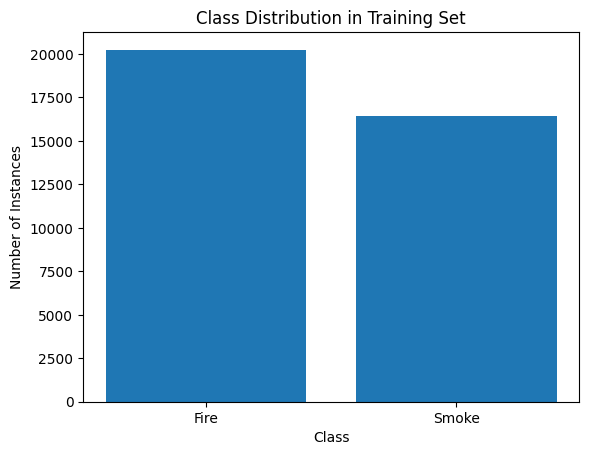

Imbalance Ratio: 1.23


In [ ]:
def count_classes(labels_dir):
    counter = Counter()
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue  # Skip non-text files

        filepath = os.path.join(labels_dir, label_file)

        try:
            with open(filepath, 'r') as f:

                for line in f:

                    line = line.strip()

                    if not line:  # Skip empty lines
                        continue
                    parts = line.split()

                    if len(parts) >= 1:  # At least class_id exists
                        class_id = int(parts[0])
                        counter[class_id] += 1
        except Exception as e:
            print(f"Error processing {filepath}: {str(e)}")
            continue

    return counter


# Define paths
train_labels_dir = os.path.join(Dataset_Path, 'train', 'labels')

# Get class counts
train_class_counts = count_classes(train_labels_dir)

# Plotting
if train_class_counts:
    class_names = {0: "Fire", 1: "Smoke"}  # Update with your actual class mapping
    classes = [class_names.get(id, f"Class_{id}") for id in train_class_counts.keys()]
    counts = list(train_class_counts.values())

    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in Training Set')
    plt.show()

    # Calculate imbalance ratio
    if len(train_class_counts) > 1:
        imbalance_ratio = max(counts) / min(counts)
        print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
    else:
        print("Warning: Only one class found in dataset")
else:
    print("No valid label files found or all files were empty")

## 7. Checking for Missing Labels

We verify that every image file has a corresponding label file in all dataset splits to ensure data completeness.


In [ ]:
#check for missing labels
def check_missing_labels(images_dir, labels_dir):
    image_files = [os.path.splitext(f)[0] for f in os.listdir(images_dir)]
    label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_dir)]

    missing_labels = list(set(image_files) - set(label_files))
    if missing_labels:
        print(f"Missing labels for {len(missing_labels)} images.")
        print(missing_labels)
    else:
        print("All images have corresponding labels.")

for split in splits:
    print(f"\nChecking {split.upper()} set:")
    images_dir = os.path.join(Dataset_Path, split, 'images')
    labels_dir = os.path.join(Dataset_Path, split, 'labels')
    check_missing_labels(images_dir, labels_dir)


Checking TRAIN set:
All images have corresponding labels.

Checking VALID set:
All images have corresponding labels.

Checking TEST set:
All images have corresponding labels.


# Exploratory Data Analysis (EDA) Report

## 1. Dataset Overview:
- Total dataset divided into three parts:
  - Training set
  - Validation set
  - Test set
- Each set contains both images and their corresponding bounding box annotations.

## 2. Visual Sample Exploration:
- Randomly selected images from each set were visualized with their bounding boxes drawn.
- Observations:
  - Images are highly varied in background, lighting, and smoke/fire visibility.
  - Bounding boxes accurately enclose smoke or fire regions.

## 3. Class Distribution:
- Training set class distributions were plotted.
- Observation:
  - Class 0 and Class 1 (e.g., Fire and Smoke) are present.
  - Some class imbalance was observed, but not severely critical.

## 4. Data Quality Check:
- Checked that every image has a corresponding label file.
- No missing labels found across train, valid, and test splits.

## 5. Conclusion:
- Dataset quality is good and ready for deep learning model training.
- Minor class imbalance can be handled during model training with techniques like class weights if necessary.


## 8. Conclusion

The dataset is well-prepared for the next phase of model development.  
We completed:
- Data verification
- Exploratory Data Analysis (EDA)
- Preprocessing pipeline setup

The project is ready to proceed to Milestone 2: **Model Training and Evaluation**.


**Milestone2**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the InceptionV3 model without the fully connected layers (top layers)
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    weights='/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)


In [ ]:
# Freeze the weights of the base model to prevent training
base_model.trainable = False

# Add custom classification layers
x = base_model.output
# Convert feature maps to a single vector
x = GlobalAveragePooling2D()(x)
# Fully connected layer with ReLU activation
x = Dense(1024, activation='relu')(x)
# Reduce overfitting by randomly dropping 50% of neurons
x = Dropout(0.5)(x)
# Output layer with softmax for multi-class classification
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 539s 467ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.2195e-06
Epoch 2/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 485s 434ms/step - accuracy: 1.0000 - loss: 7.0139e-07 - val_accuracy: 1.0000 - val_loss: 1.9370e-07
Epoch 3/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 482s 432ms/step - accuracy: 1.0000 - loss: 1.4816e-07 - val_accuracy: 1.0000 - val_loss: 7.0688e-08
Epoch 4/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 478s 428ms/step - accuracy: 1.0000 - loss: 6.8214e-08 - val_accuracy: 1.0000 - val_loss: 3.3603e-08
Epoch 5/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 483s 433ms/step - accuracy: 1.0000 - loss: 1.1808e-07 - val_accuracy: 1.0000 - val_loss: 1.6668e-08
Epoch 6/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 476s 427ms/step - accuracy: 1.0000 - loss: 1.6276e-08 - val_accuracy: 1.0000 - val_loss: 1.1380e-08
Epoch 7/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 481s 431ms/step - accuracy: 1.0000 - loss: 1.8294e-08 - val_accuracy: 1.0000 - val_loss: 6.6769e-09
Epoch 8/10

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 4.1733e-10
Test Accuracy: 1.0000
Test Loss: 0.0000


In [ ]:
# saving model
model.save('/content/drive/MyDrive/classification_model.h5')

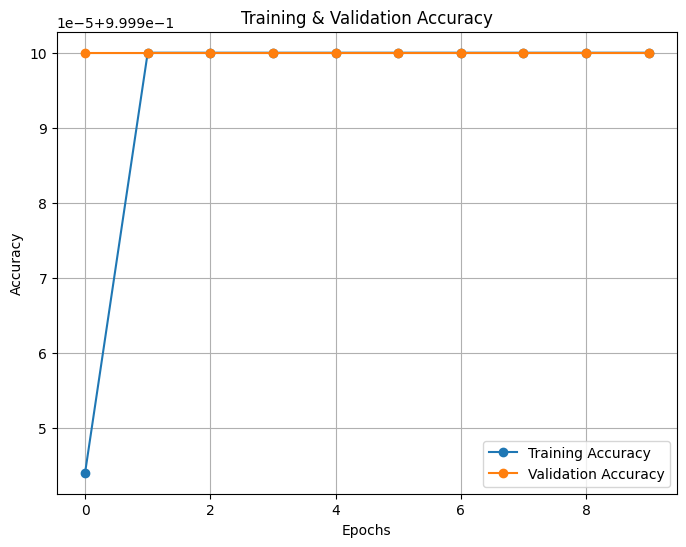

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract loss values (optional)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="Training Accuracy", marker="o")
plt.plot(val_acc, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

**Yolo for object detection**

In [12]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 nano model
model = YOLO('yolov8n.pt')

# Train the model on your custom dataset
model.train(
    data='/content/Fire and Smoke Dataset/data.yaml',
    epochs=30,
    imgsz=512,
    batch=16,
    name='smoke_fire_model',
    plots=True,   # Enable saving and displaying plots for metrics
    save=True     # Save model after training
)

# Step 3: Save the trained model
model.save('/content/drive/MyDrive/detection_model')  # Saving the model to the specified location


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Fire and Smoke Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=smoke_fire_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

train: Scanning /content/Fire and Smoke Dataset/train/labels... 35695 images, 9046 backgrounds, 0 corrupt: 100%|██████████| 35695/35695 [00:23<00:00, 1548.72it/s]


train: New cache created: /content/Fire and Smoke Dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2916, len(boxes) = 36668. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.9±2.0 ms, read: 6.5±4.1 MB/s, size: 23.7 KB)


val: Scanning /content/Fire and Smoke Dataset/valid/labels... 4892 images, 855 backgrounds, 0 corrupt: 100%|██████████| 4892/4892 [00:04<00:00, 1151.82it/s]

val: New cache created: /content/Fire and Smoke Dataset/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 291, len(boxes) = 6085. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/smoke_fire_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/smoke_fire_model2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.29G      1.601      2.864      1.632         34        512: 100%|██████████| 2231/2231 [07:59<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:34<00:00,  4.38it/s]


                   all       4892       6085      0.525      0.298      0.327      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.67G      1.616      2.304      1.629         26        512: 100%|██████████| 2231/2231 [07:57<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:34<00:00,  4.46it/s]


                   all       4892       6085      0.572      0.341      0.369      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.67G      1.691       2.33      1.696         18        512: 100%|██████████| 2231/2231 [07:53<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:34<00:00,  4.44it/s]


                   all       4892       6085      0.567      0.348      0.377      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.67G        1.7      2.308      1.727         32        512: 100%|██████████| 2231/2231 [07:57<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:35<00:00,  4.29it/s]


                   all       4892       6085      0.591      0.395      0.447      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.69G      1.623      2.147       1.67         29        512: 100%|██████████| 2231/2231 [08:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:36<00:00,  4.19it/s]


                   all       4892       6085      0.609      0.449      0.501      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       1.7G      1.572      2.029      1.629         22        512: 100%|██████████| 2231/2231 [07:59<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.73it/s]


                   all       4892       6085      0.611      0.476      0.537      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.71G       1.54      1.941      1.603         31        512: 100%|██████████| 2231/2231 [07:54<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.54it/s]


                   all       4892       6085      0.646      0.502      0.563      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.71G      1.515      1.875       1.58         29        512: 100%|██████████| 2231/2231 [07:52<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.83it/s]


                   all       4892       6085      0.686      0.491      0.572      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.72G      1.486      1.814      1.562         29        512: 100%|██████████| 2231/2231 [07:41<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.82it/s]


                   all       4892       6085      0.684      0.518      0.593      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.74G      1.471      1.772      1.545         20        512: 100%|██████████| 2231/2231 [07:39<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.56it/s]


                   all       4892       6085      0.675      0.545      0.614      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.75G      1.445      1.709      1.524         29        512: 100%|██████████| 2231/2231 [07:48<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.66it/s]


                   all       4892       6085      0.719       0.53      0.618      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.76G      1.431      1.665      1.505         18        512: 100%|██████████| 2231/2231 [07:48<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.56it/s]


                   all       4892       6085      0.709      0.555      0.632      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.77G      1.411      1.612       1.49         26        512: 100%|██████████| 2231/2231 [07:58<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.63it/s]


                   all       4892       6085      0.719      0.565      0.646      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.78G      1.391      1.576      1.478         35        512: 100%|██████████| 2231/2231 [07:52<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.73it/s]


                   all       4892       6085       0.73      0.567      0.651      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.79G      1.366      1.523       1.46         34        512: 100%|██████████| 2231/2231 [07:47<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.80it/s]


                   all       4892       6085      0.735      0.581      0.659      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       1.8G      1.354      1.494      1.443         42        512: 100%|██████████| 2231/2231 [07:48<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.65it/s]


                   all       4892       6085      0.732      0.593      0.668      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.81G      1.344      1.462      1.432         40        512: 100%|██████████| 2231/2231 [07:54<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.90it/s]


                   all       4892       6085      0.717      0.603      0.672      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.82G      1.326      1.423      1.422         21        512: 100%|██████████| 2231/2231 [07:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.80it/s]


                   all       4892       6085       0.74      0.604      0.679      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.83G      1.301      1.384      1.402         35        512: 100%|██████████| 2231/2231 [07:41<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.71it/s]


                   all       4892       6085      0.753      0.608      0.686        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.85G       1.29      1.357      1.396         19        512: 100%|██████████| 2231/2231 [07:44<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.76it/s]


                   all       4892       6085      0.757      0.615      0.694      0.407
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.86G      1.339      1.214      1.441         11        512: 100%|██████████| 2231/2231 [07:26<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.80it/s]


                   all       4892       6085      0.763      0.623      0.701      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.87G      1.306      1.153      1.414         17        512: 100%|██████████| 2231/2231 [07:20<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.90it/s]

                   all       4892       6085      0.772      0.621      0.707      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.88G      1.269      1.101      1.393         10        512: 100%|██████████| 2231/2231 [07:14<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.60it/s]


                   all       4892       6085      0.762       0.63      0.712       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.89G      1.248      1.064      1.377         14        512: 100%|██████████| 2231/2231 [07:32<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:31<00:00,  4.88it/s]


                   all       4892       6085      0.757      0.638      0.716      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       1.9G      1.223      1.024      1.357         12        512: 100%|██████████| 2231/2231 [07:27<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.63it/s]

                   all       4892       6085      0.758      0.641       0.72      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.91G      1.202     0.9908      1.342         12        512: 100%|██████████| 2231/2231 [07:14<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:33<00:00,  4.60it/s]


                   all       4892       6085      0.768      0.644      0.724      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.92G      1.182     0.9617      1.329         11        512: 100%|██████████| 2231/2231 [07:16<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.73it/s]


                   all       4892       6085      0.771      0.647      0.727      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.94G      1.155       0.93      1.306         18        512: 100%|██████████| 2231/2231 [07:17<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:32<00:00,  4.68it/s]


                   all       4892       6085      0.781      0.644       0.73      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.95G      1.127     0.9026      1.293         19        512:  35%|███▌      | 786/2231 [02:34<06:11,  3.89it/s]

In [ ]:
# model.save('/content/drive/MyDrive/detection_model.h5')

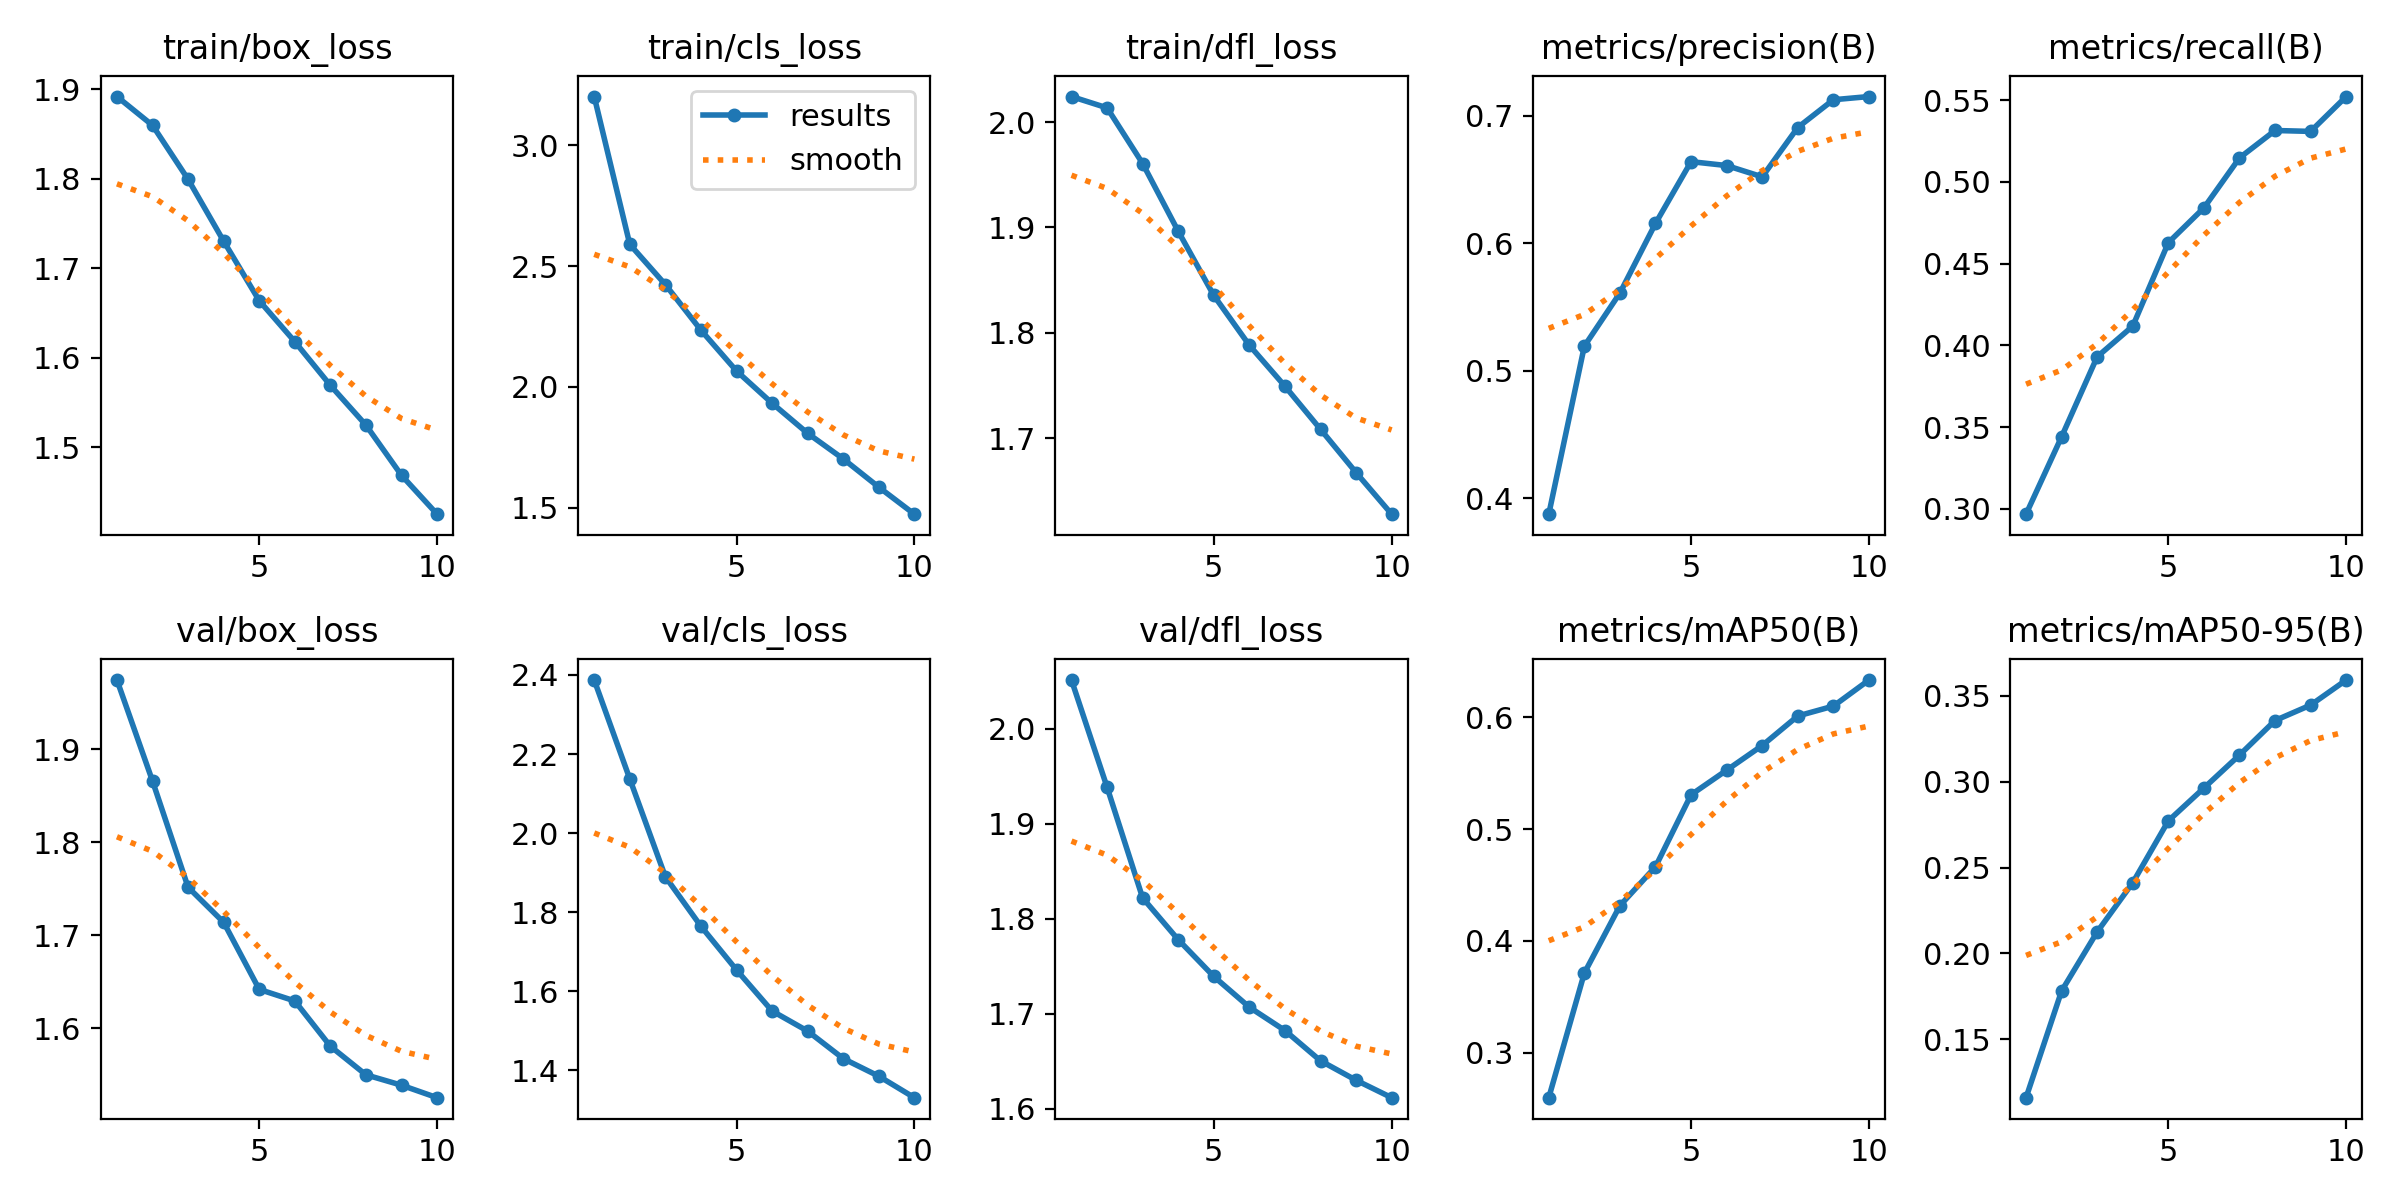

In [ ]:
from IPython.display import Image
Image(filename='/content/runs/detect/smoke_fire_model/results.png')


In [ ]:
# Step 4: Run predictions on test images
results = model.predict('/content/Fire and Smoke Dataset/test/images', conf=0.25)  # Run predictions on test images with a confidence threshold of 25%

# Step 5: Show and save the prediction results (images with bounding boxes)
for result in results:
    # Show the image with bounding boxes drawn by the model
    result.show()  # Plots detection results on the image with clearer bounding boxes

    # Optionally, save the prediction results in a folder
    result.save()  # Saves the images with bounding boxes in the "runs/detect/predict" folder

    # Print prediction details (e.g., the number of objects detected, class names, and confidence)
    print(f"Predictions (as DataFrame): {result.to_df()}")  # Now using `to_df()` to get predictions in a pandas DataFrame format


